# SchW-BERT-GAN データ前処理
theorytabデータセットを使ったSchW-BERT-GAN用データの処理  
melody, chord, metaをまとめたデータをbundleと呼び，その数をbundle_numとする

theorytabデータセットは https://github.com/wayne391/lead-sheet-dataset からダウンロードできる  
theorytabデータセットの解析ファイルの作成は https://github.com/fuurin/midi/blob/master/TheoryTab.ipynb

In [1]:
import os, random
import hickle as hkl
import numpy as np
import pandas as pd
from pypianoroll import Multitrack, Track
import matplotlib.pyplot as plt
%matplotlib inline

from multiprocessing import Pool, cpu_count
print(f"{cpu_count()} cpus are available.")

# カレントディレクトリをリポジトリ直下にして自家製モジュールをimport
while os.getcwd().split('/')[-1] != 'schwbert': os.chdir('..')
print('current dir:', os.getcwd())
from utils import Timer, Sampler, grid_plot
from preparation.bundle import Bundle, PypianorollBundler
from preparation.processor import BundlesProcessor, SequentialBundlesProcessor

32 cpus are available.
current dir: /root/schwbert


In [2]:
base_dir = "../datasets"
theorytab_dir = os.path.join(base_dir, "theorytab")
input_dir = os.path.join(theorytab_dir, "pianoroll")
input_csv = os.path.join(theorytab_dir, "theorytab.csv")

schwbert_dir = os.path.join(base_dir, "schwbert")
output_base_dir = os.path.join(schwbert_dir, "data")
output_dir = os.path.join(output_base_dir, "theorytab")

for directory in [schwbert_dir, output_base_dir, output_dir]:
    if not os.path.exists(directory):
        os.mkdir(directory)

In [3]:
df = pd.read_csv(input_csv)
df = df[(df["nokey"] == False) & (df["time_signature"] == "4/4")]
df = df[df["has_melody_track"] & df["has_chord_track"]]
df = df.reset_index()

sampler = Sampler(base_dir=input_dir, dataframe=df)
print(df.shape)
df.head()

(16386, 23)


,index,Unnamed: 0,path,artist,song,section,nokey,key_signature,estimated_key_signature,in_scale_rate,...,lowest_melody,highest_chord,lowest_chord,bpm,time_signature,beats,bars,time,has_melody_track,has_chord_track
0,0,0,q/quincy-jones-and-his-orchestra/soul-bossa-no...,quincy-jones-and-his-orchestra,soul-bossa-nova,chorus,False,Bb Major,Bb Major,0.88278,...,65.0,63.0,43.0,146,4/4,48,12,19.73,True,True
1,2,2,q/queen-and-bowie/under-pressure/intro-and-ver...,queen-and-bowie,under-pressure,"intro,verse",False,D Major,D Major,1.00000,...,57.0,57.0,45.0,120,4/4,32,8,16.00,True,True
2,5,5,q/queen-and-bowie/under-pressure/intro_key.mid,queen-and-bowie,under-pressure,intro,False,D Major,D Major,1.00000,...,57.0,61.0,50.0,240,4/4,32,8,8.00,True,True
3,8,8,q/queen/the-show-must-go-on/intro-and-verse_ke...,queen,the-show-must-go-on,"intro,verse",False,B Major,B minor,0.64627,...,70.0,59.0,42.0,83,4/4,57,14,40.48,True,True
4,10,10,q/queen/the-show-must-go-on/bridge_key.mid,queen,the-show-must-go-on,bridge,False,C Major,A minor,1.00000,...,57.0,60.0,43.0,84,4/4,24,6,17.14,True,True


id: 0
path: q/quincy-jones-and-his-orchestra/soul-bossa-nova/chorus_key.mid


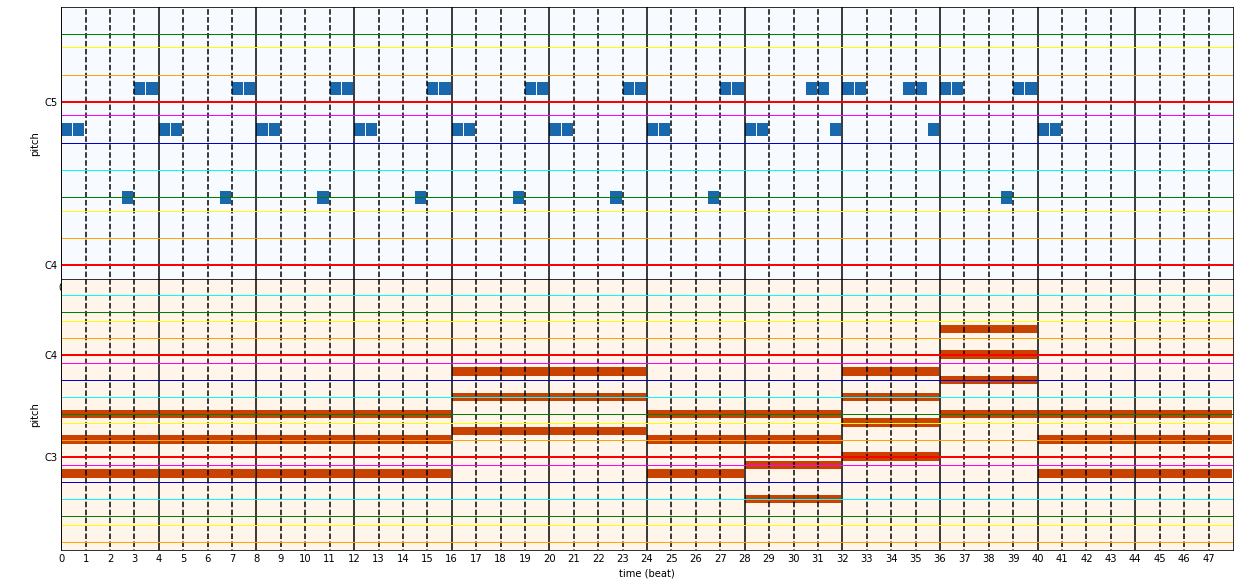

In [4]:
ppr = sampler.ppr(with_row=False)
grid_plot(ppr)

# original
- 全体的なこと
    - resolutionを12にして音符の切れ目を一番後ろ空白にする
    - スケール外の音が生成されてしまうのでトランスポーズによる水増しを行わない
    - 長さの固定
        - 16小節未満のものは残りスペースのPAD部分を1にする
        - 16小節を超えるものは16小節ごとに分割
        - 4小節未満のものは使わない
        - 複数のphraseが得られることがあるので，並列処理の返り値はリストのリスト
            - あとで直列にする
- メロディのこと
    - (768, 67)
    - 提示されているkeyはあてにならないので，estimated_keyに合わせてCもしくはAmへトランスポーズ
    - MIDI音程を36～99(99を含む, C2~D#7)の64ピッチ以内にシフトし， ピッチ方向は64入力のモデルで学習
    - id=64は休符． 音程がない部分の音程を1にする
    - id=65の音程はマスク用なので0にしておく
    - id=66の音程はPAD
    - メロディ密度が全体の半分未満のデータは削除
- コードのこと
    - (768, 13)
    - few-hot vectorを使用 -> 12で割って得られたピッチをそのまま使う. 展開形などにも対応できる
    - id=12の音程はPAD
    - midinetのように，後ろ(先頭は前へ)に伸ばすことで全てのステップで何かしら鳴っているようにする
        - 現在のステップの和音が，前のステップの和音の部分集合であるとき，前のステップの和音で上書きする
        - ちなみに空集合はあらゆる集合の部分集合なので後ろに伸ばすことにもなる
        - pythonはリストまたはset同士の包含関係の演算を<=演算子で(N=1Mを0.01秒で!)行える
            - と思ったけどnumpy配列なので別の方法をとる
- メタ情報のこと
    - 辞書型で保存
    - file_name
    - bars_range (0スタート) ex. 0-16
    - bpm
    - original_bars (小節数)
    - bars
    - beat_resolution
    - beats_in_bar
    - melody_offset

## 処理の手順
melody(numpy配列), chord(numpy配列), meta(辞書)がBundleになったリストを取得  
- PypianorollBundler.bundle(ppr, row)
  
Bundleに施すProcessor
- RemoveEmptyBundles
- RemoveShortBundles
- Binarize
- DownBeatResolution
    - meta['beat_resolution']を更新
- Transpose
- メロディに影響するもの
    - TrimMelodyInRange
        - meta['melody_offset']を追加
        - meta['melody_pitch_range']を追加
    - AddSpecialPitchesToMelody
- コードに影響するもの
    - TranslateChordIntoPitchClasses
        - meta['chord_offset']を追加
        - meta['chord_pitch_range']を追加
    - PermeateChord
    - AddSpecialPitchesToChord
- Padding
    - meta['bars']を設定

### Bundleへ分割

In [5]:
bundler = PypianorollBundler()

動作確認

path: a/alan-silvestri/the-cosmos-is-yours---cosmos-a-spacetime-odyssey/instrumental_key.mid


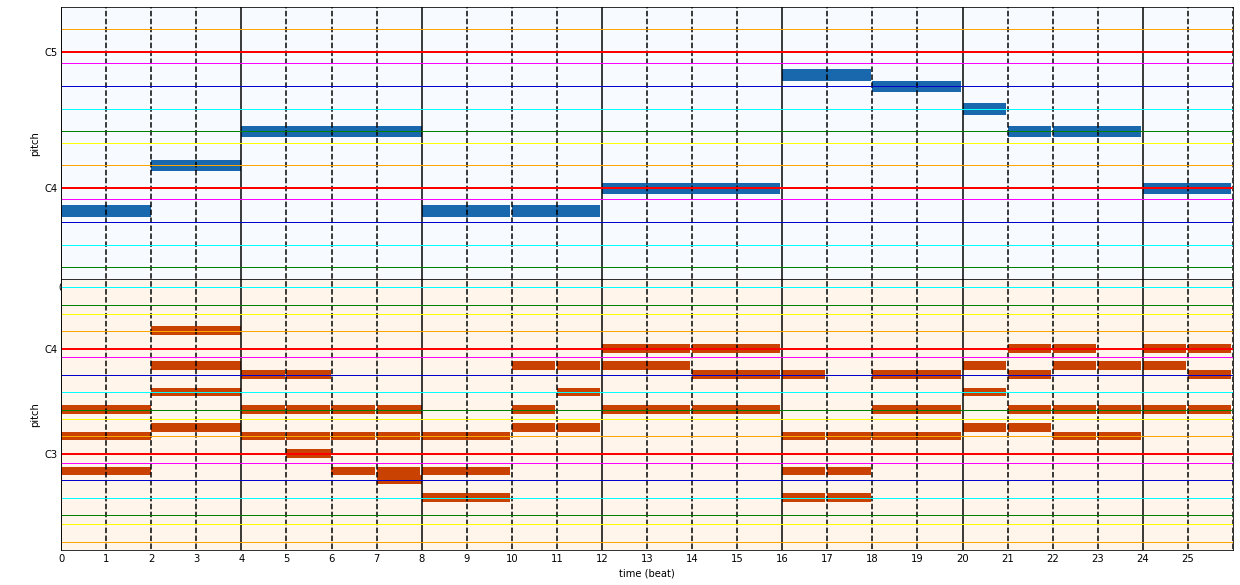

In [6]:
lack_path = 'a/alan-silvestri/the-cosmos-is-yours---cosmos-a-spacetime-odyssey/instrumental_key.mid'
extra_path = 'q/queen/the-show-must-go-on/intro-and-verse_key.mid'
ppr, row = sampler.ppr_by_path(lack_path)
grid_plot(ppr)

In [7]:
with Timer():
    bundles = bundler.bundle(ppr, row)

print(f"{len(bundles)} bundle(s)")
bundle = bundles[0]
print(f"melody shape: {bundle.melody.shape}")
print(f"chord shape: {bundle.chord.shape}")
bundle.get_dict()

0.001019
1 bundle(s)
melody shape: (672, 128)
chord shape: (672, 128)


{'melody': array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]),
 'chord': array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]),
 'meta': {'range_from': 0,
  'range_for': 7,
  'original_bars': 7,
  'beat_resolution': 24,
  'beats_in_bar': 4,
  'path': 'a/alan-silvestri/the-cosmos-is-yours---cosmos-a-spacetime-odyssey/instrumental_key.mid',
  'bpm': 58,
  'original_key': 'Bb Major'}}

a/alan-silvestri/the-cosmos-is-yours---cosmos-a-spacetime-odyssey/instrumental_key.mid


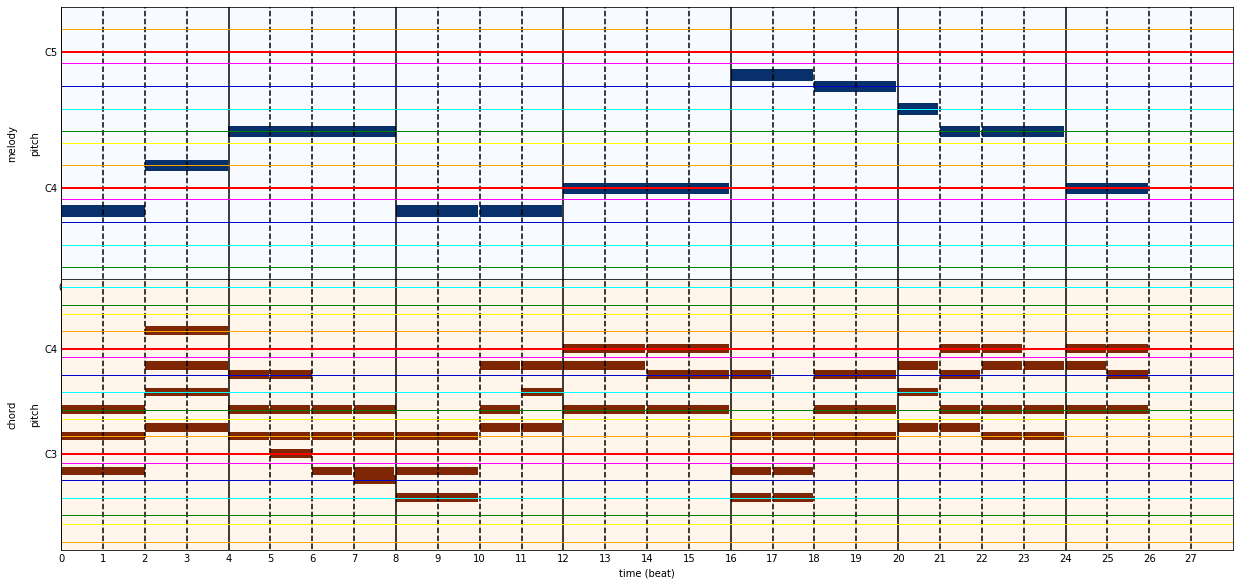

In [8]:
ppr = bundle.get_ppr()
print(ppr.name)
grid_plot(ppr)

### メロディかコードが空のバンドルを削除する

In [9]:
class RemoveEmptyBundles(BundlesProcessor):
    def process_bundle(self, bundle):
        melody_is_empty = not bundle.melody.any()
        chord_is_empty = not bundle.chord.any()
        
        if melody_is_empty or chord_is_empty:
            return None
        
        return bundle

In [10]:
remove_empty_bundles = RemoveEmptyBundles()

path = "c/covesthur/dayresponse/chorus_key.mid"
ppr, row = sampler.ppr_by_path(path)
bundles = bundler.bundle(ppr, row)

print(len(bundles), "bundles")

with Timer():
    bundles = remove_empty_bundles(bundles)

print(len(bundles), "bundles")

path: c/covesthur/dayresponse/chorus_key.mid
2 bundles
0.000560
1 bundles


### 短いbundleを削除する

In [11]:
class RemoveShortBundles(BundlesProcessor):
    """
    初期化引数threshold_barsより小さい小節数のBundleを削除
    """
    def __init__(self, threshold_bars=4):
        self.threshold_bars = threshold_bars

    def process_bundle(self, bundle):
        if bundle.meta["original_bars"] < self.threshold_bars:
            return None
        return bundle

動作確認

In [12]:
remove_short_bundles = RemoveShortBundles()

short_path = "q/queen/bohemian-rhapsody/pre-chorus-and-chorus_key.mid" # 2 bars file
long_path = "q/queen/bohemian-rhapsody/bridge_key.mid" # 19 bars_file
ppr, row = sampler.ppr_by_path(long_path)
bundles = bundler.bundle(ppr, row)

with Timer():
    bundles = remove_short_bundles(bundles)

len(bundles)

path: q/queen/bohemian-rhapsody/bridge_key.mid
0.000007


1

### 二値化する

In [13]:
class Binarize(BundlesProcessor):
    """
    melody, chordをboolへ変換
    ベロシティが0ならFalse,1以上ならTrueとなる
    """
    def process_bundle(self, bundle):
        bundle.melody = bundle.melody.astype(bool)
        bundle.chord = bundle.chord.astype(bool)
        return bundle

動作確認

In [14]:
binarize = Binarize()

short_path = "q/queen/bohemian-rhapsody/pre-chorus-and-chorus_key.mid" # 2 bars file
long_path = "q/queen/bohemian-rhapsody/bridge_key.mid" # 19 bars_file
ppr, row = sampler.ppr_by_path(long_path)
bundles = bundler.bundle(ppr, row)

print(bundles[0].melody.dtype)

with Timer():
    bundles = binarize(bundles)

print(bundles[0].melody.dtype)

path: q/queen/bohemian-rhapsody/bridge_key.mid
uint8
0.000319
bool


### beat_resolutionを下げる

In [15]:
class DownBeatResolution(BundlesProcessor):
    """
    melody, chordのbeat_resolutionを下げる
    metaのbeat_resolutionも更新される
    """
    def __init__(self, resolution_to, resolution_from=None, fill_mode=False):
        self.res_to = resolution_to
        self.fill_mode = fill_mode

    def down_resolution(self, nproll, step_width):
        result = nproll[::step_width]
        if not self.fill_mode:
            note_existence = nproll.astype(bool)
            for s in range(1, step_width):
                result *= note_existence[s::step_width]
        return result
    
    def process_bundle(self, bundle):
        res_from = bundle.meta['beat_resolution']
        
        if self.res_to >= res_from:
            raise ValueError(f"Target resolution ({self.res_to}) must be \
                             smaller than the original resolution ({res_from})")
        
        step_width = res_from // self.res_to
        
        bundle.melody = self.down_resolution(bundle.melody, step_width)
        bundle.chord = self.down_resolution(bundle.chord, step_width)
        bundle.meta['beat_resolution'] = self.res_to
        
        return bundle

動作確認

In [16]:
down_beat_resolution = DownBeatResolution(12)

short_path = "q/queen/bohemian-rhapsody/pre-chorus-and-chorus_key.mid" # 2 bars file
long_path = "q/queen/bohemian-rhapsody/bridge_key.mid" # 19 bars_file
ppr, row = sampler.ppr_by_path(long_path)
bundles = bundler.bundle(ppr, row)

bundle_id = 0
print(bundles[bundle_id].meta['beat_resolution'])
print(bundles[bundle_id].melody.shape)
print(bundles[bundle_id].chord.shape)

with Timer():
    bundles = down_beat_resolution(bundles)

print(bundles[bundle_id].meta['beat_resolution'])
print(bundles[bundle_id].melody.shape)
print(bundles[bundle_id].chord.shape)

path: q/queen/bohemian-rhapsody/bridge_key.mid
24
(1536, 128)
(1536, 128)
0.000756
12
(768, 128)
(768, 128)


### CまたはAmへトランスポーズする

In [17]:
class Transpose(BundlesProcessor):
    """
    to_keyはメジャースケールにおける主音
    例えば to_key=0 のとき, C minor を渡せば A minor へトランスポーズする
    変更元のkeyを後で変更できるのでインスタンスを再生成しなくていい
    変換後シフト量が取得できるので，別のトラックのシフトに再利用できる
    """
    def __init__(self, from_key_name="C Major", to_key=0, standard_pitch_range=[36,99]):
        self.set_key_names_dict()
        self.set_key(from_key_name, to_key)
        self.std_bottom, self.std_top = standard_pitch_range
    
    def set_key_names_dict(self):
        self.sharp_key_names = ['C', 'C#', 'D', 'D#', 'E', 'F', 'F#', 'G', 'G#', 'A', 'A#', 'B']
        self.flat_key_names  = ['C', 'Db', 'D', 'Eb', 'E', 'F', 'Gb', 'G', 'Ab', 'A', 'Bb', 'B']
        self.key_names_dict = {}
        for i, (name_s, name_f) in enumerate(zip(self.sharp_key_names, self.flat_key_names)):
            self.key_names_dict[name_s], self.key_names_dict[name_f] = i, i
        
    def set_key(self, key_name, to_key=0):
        key_name, mode = key_name.split(' ')
        self.from_key = self.key_names_dict[key_name]
        self.to_key = (to_key - 3) % 12 if mode == "minor" else to_key
        key_name_list = self.sharp_key_names if '#' in key_name else self.flat_key_names
        self.to_key_name = ' '.join([key_name_list[self.to_key], mode])
        
    def get_active_range(self, nproll):
        pitches = np.where(nproll)[1]
        return np.min(pitches), np.max(pitches)
    
    def process_nproll(self, nproll):
        # standatd_pitch_rangeで移動後のlowestとhighestを囲った時，マージンの大きい方へトランスポーズする
        lowest, highest = self.get_active_range(nproll)
        shift_down      = (self.from_key - self.to_key) % 12
        shift_up        = (self.to_key - self.from_key) % 12
        margin_bottom   = (lowest - shift_down) - self.std_bottom
        margin_top      = self.std_top - (highest + shift_up)
        shift           = shift_up if margin_top > margin_bottom else -shift_down
        
        if shift != 0:
            transposed = np.zeros_like(nproll, dtype=nproll.dtype)
            transposed[:, lowest+shift:highest+shift+1] = nproll[:, lowest:highest+1]
            return transposed
        
        return nproll
            
    def process_bundle(self, bundle):
        self.set_key(bundle.meta['original_key'], to_key=self.to_key)
        
        bundle.melody = self.process_nproll(bundle.melody)
        bundle.chord = self.process_nproll(bundle.chord)
        bundle.meta['key'] = self.to_key_name
        
        return bundle

動作確認

path: q/queen/bohemian-rhapsody/pre-chorus-and-chorus_key.mid
original_key: Bb minor


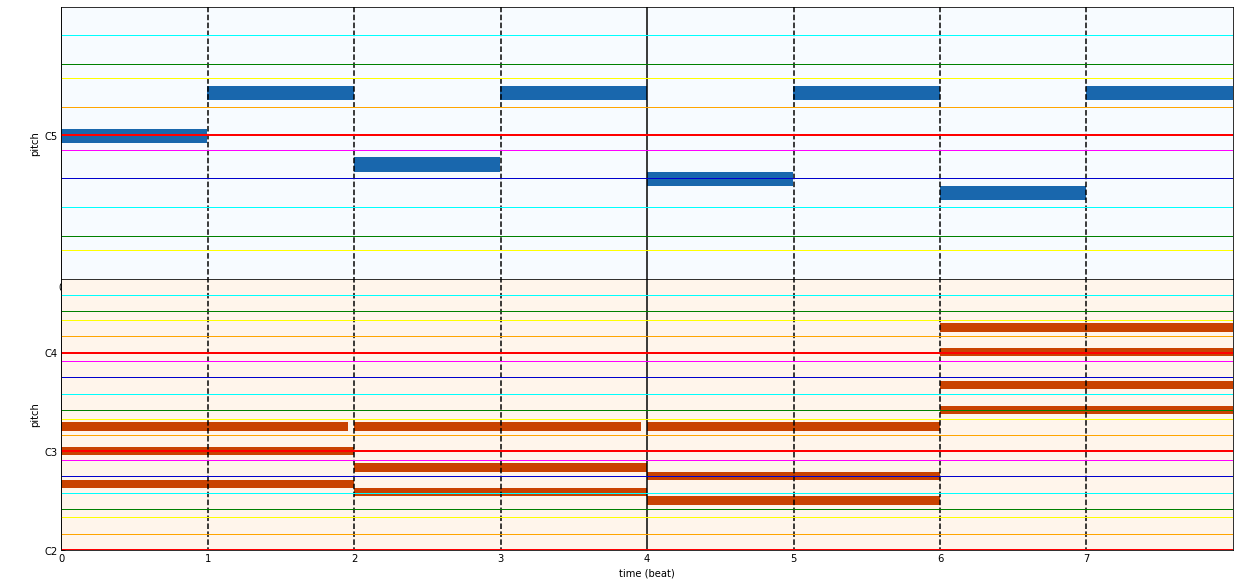

In [18]:
transpose = Transpose()

short_path = "q/queen/bohemian-rhapsody/pre-chorus-and-chorus_key.mid" # 2 bars file
long_path = "q/queen/bohemian-rhapsody/bridge_key.mid" # 19 bars_file
ppr, row = sampler.ppr_by_path(short_path)
bundles = bundler.bundle(ppr, row)

print(f"original_key: {bundles[0].meta['original_key']}")
grid_plot(ppr)

0.000916
A minor


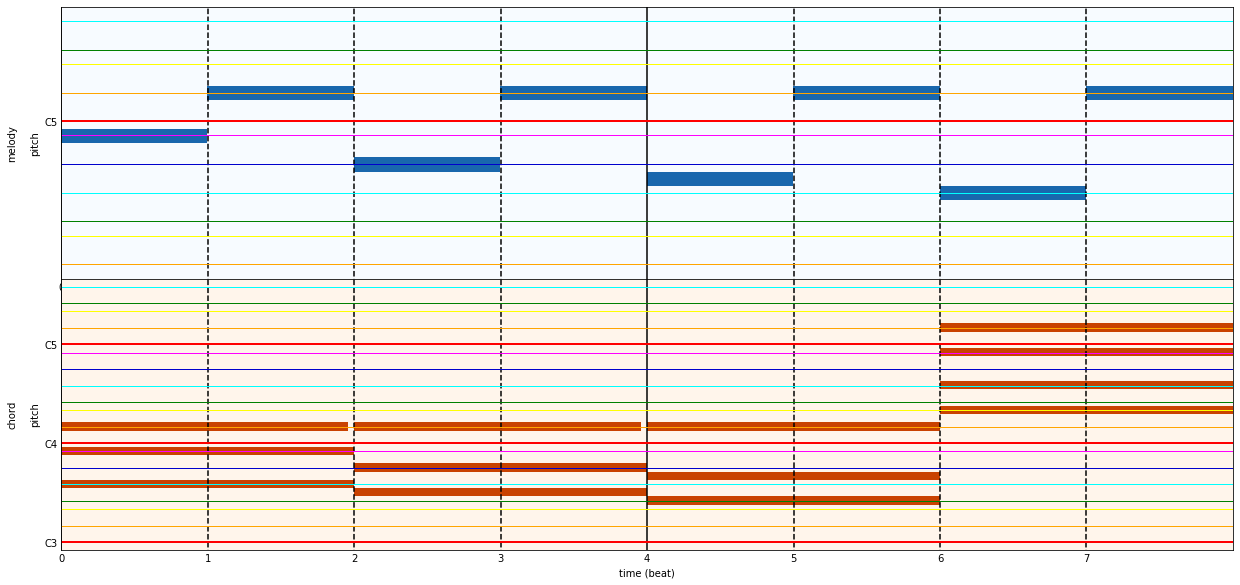

In [19]:
with Timer():
    bundles = transpose(bundles)

print(bundles[0].meta['key'])
grid_plot(bundles[0].get_ppr())

### メロディをC2~D#7の中にシフト
例によってロスの少ないC2～D#7 (36,99)の中に「全体を」シフト  
一応注意: pretty_midiのpitch=0はC-1でpypianorollのplotのpitch=0はC-2だった  
もっとも大きなピッチレンジは62なので, 上下両方にはみ出すことはない．  
シフトした結果，元の譜面よりはみ出ている部分がさらに多くなるケースは，2曲しか発生しないので無視する  
  
meta['melody_offset']とmeta['melody_pitch_range']を追加し，サイズが変わってもbundle.get_pprできるようにする

In [20]:
class TrimMelodyInRange(BundlesProcessor):
    def __init__(self, bottom, top, keep_size=False):
        if bottom < 0 or top > 127:
            raise ValueError("Pitch range must be in [0, 127].")
        if top - bottom < 12:
            raise ValueError("Pitch range must be larger than 12 pitches.")
        self.bottom, self.top = bottom, top
        self.keep_size = keep_size
    
    def get_active_range(self, nproll):
        pitches = np.where(nproll)[1]
        return np.min(pitches), np.max(pitches)
    
    def process_bundle(self, bundle):
        nproll = bundle.melody
        
        bottom, top = self.bottom, self.top
        
        lowest, highest = self.get_active_range(nproll)
        
        bottom_saturation = bottom - lowest
        top_saturation = highest - top
        
        if bottom_saturation > 0:
            shift_octave = - (bottom_saturation // 12 + 1)
        elif top_saturation > 0:
            shift_octave = top_saturation // 12 + 1
        else:
            shift_octave = 0
        
        shift_amount = shift_octave * 12
        shifted_bottom, shifted_top = bottom + shift_amount, top + shift_amount
        
        if self.keep_size:
            nproll[:, bottom:top+1] = nproll[:, shifted_bottom:shifted_top+1]
            nproll[:, :bottom] = 0
            nproll[:, top+1:] = 0
            bundle.meta['melody_offset'] = 0
            bundle.meta['melody_pitch_range'] = [0, nproll.shape[1]]
        else:
            nproll = nproll[:, shifted_bottom:shifted_top+1]
            bundle.meta['melody_offset'] = shifted_bottom
            bundle.meta['melody_pitch_range'] = [0, top - bottom + 1]
        
        bundle.melody = nproll
        
        return bundle

動作確認

path: l/lorn/sega-sunset/intro-and-verse_key.mid
highest: 66.0, lowest: 22.0


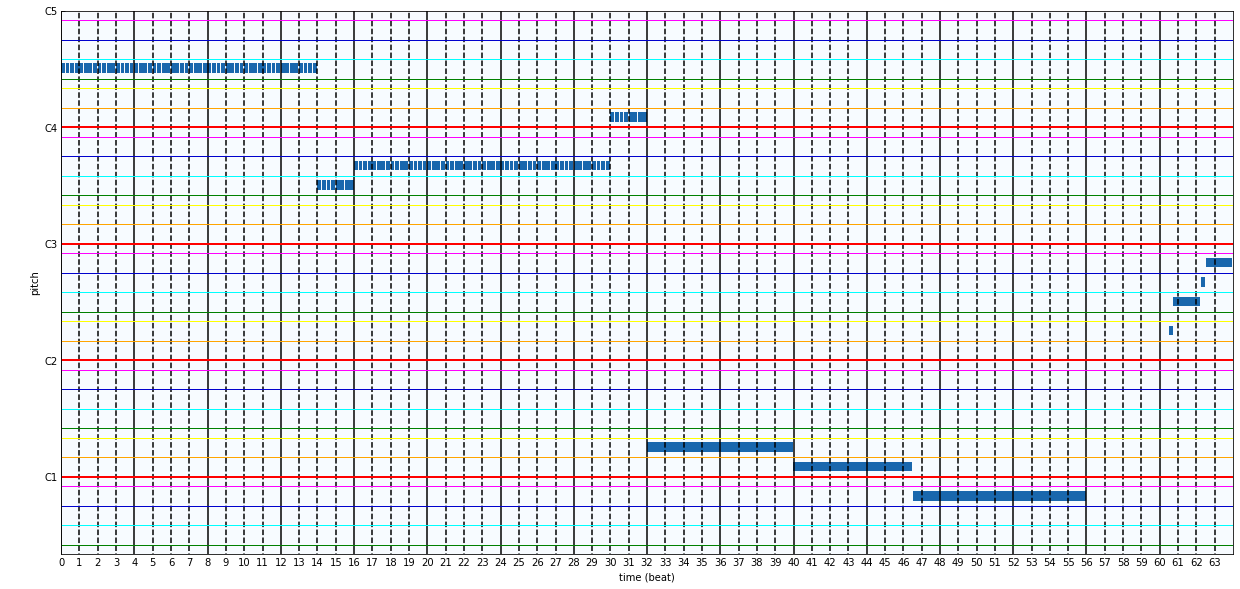

In [21]:
high_path = "f/flo-rida/whistle/instrumental_key.mid" # highest=105
low_path = "l/lorn/sega-sunset/intro-and-verse_key.mid" # lowest=22
path = low_path
ppr, row = sampler.ppr_by_path(path)

print(f"highest: {row['highest_melody']}, lowest: {row['lowest_melody']}")
ppr.tracks.pop()
grid_plot(ppr)

path: l/lorn/sega-sunset/intro-and-verse_key.mid
0.001136
melody_shape: (1536, 64)
offset: 12
pitch_range: [0, 64]
shifted range: [22, 66]


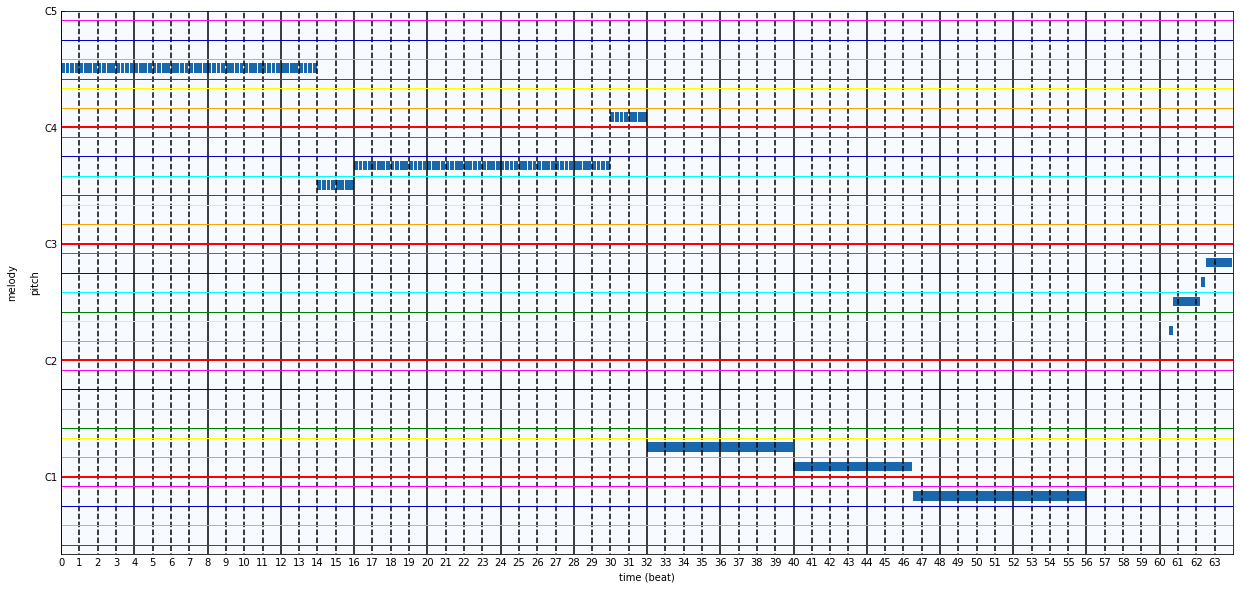

In [22]:
ppr, row = sampler.ppr_by_path(path)
bundles = bundler.bundle(ppr)

trim_melody_in_range = TrimMelodyInRange(bottom=36, top=99, keep_size=False)

with Timer():
    bundles = trim_melody_in_range(bundles)

bundle = bundles[0]
offset = bundle.meta['melody_offset']
shifted_range = trim_melody_in_range.get_active_range(bundle.melody)
shifted_range = [pitch + offset for pitch in shifted_range]

print(f"melody_shape: {bundle.melody.shape}")
print(f"offset: {offset}")
print(f"pitch_range: {bundle.meta['melody_pitch_range']}")
print(f"shifted range: {shifted_range}")

bundle.chord = None
grid_plot(bundle.get_ppr())

### 特殊ピッチをメロディに加える
- id=64: REST, 休符． 音程がない部分の音程を1にする
- id=65: MASK, 0にしておく
- id=66: PAD あとでPaddingでセット(chordとmelodyの長い方から先をPADにするため)

In [23]:
class AddSpecialPitchesToMelody(BundlesProcessor):
    def set_rest_pitch(self, nproll, pitch):
        nproll[:, pitch] = nproll.any(axis=1) == False
        return nproll
    
    def process_bundle(self, bundle):
        melody = bundle.melody
        step_len, pitch_len = melody.shape
        
        extended_melody = np.zeros([step_len, pitch_len + 3], dtype=melody.dtype)
        extended_melody[:, :pitch_len] = melody
        extended_melody = self.set_rest_pitch(extended_melody, pitch_len)
        
        bundle.melody = extended_melody
        return bundle

動作確認

path: q/queen/bohemian-rhapsody/bridge_key.mid
(1536, 128)
0.000944
(1536, 131)


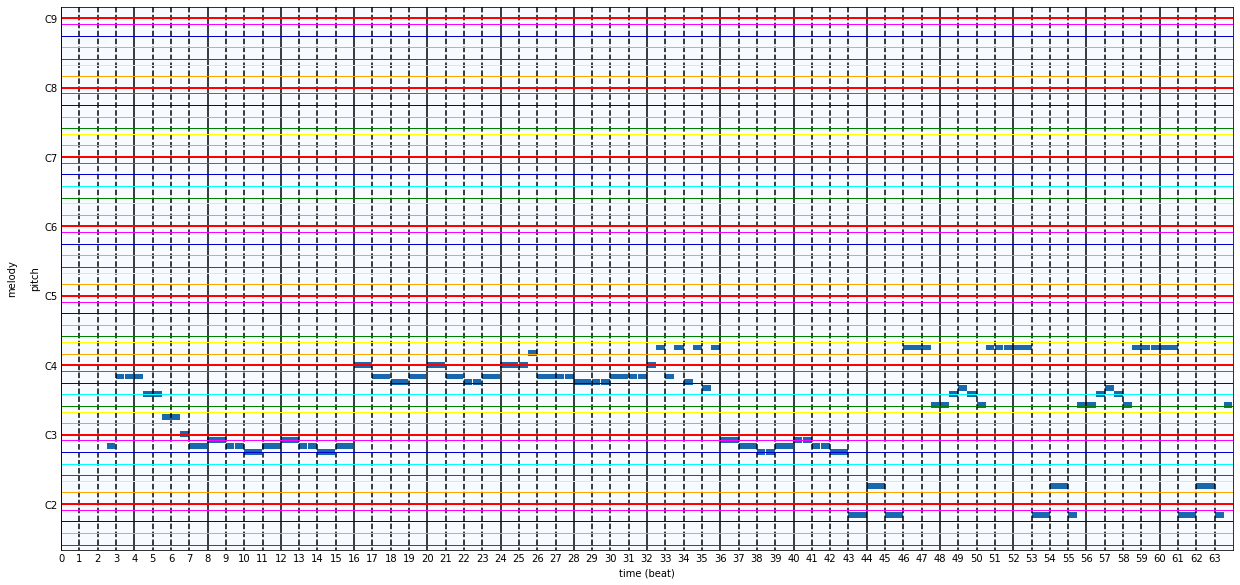

In [24]:
add_special_pitches_to_melody = AddSpecialPitchesToMelody()

short_path = "q/queen/bohemian-rhapsody/pre-chorus-and-chorus_key.mid" # 2 bars file
long_path = "q/queen/bohemian-rhapsody/bridge_key.mid" # 19 bars_file
ppr, row = sampler.ppr_by_path(long_path)
bundles = bundler.bundle(ppr, row)

bundle_id = 0
print(bundles[bundle_id].melody.shape)

with Timer():
    bundles = add_special_pitches_to_melody(bundles)

bundle = bundles[bundle_id]
bundle.meta['melody_pitch_range'] = [12, 128+3] # include special pitches
bundle.chord = None
print(bundle.melody.shape)
grid_plot(bundle.get_ppr())

### コードをピッチクラスに変換
(length, 12)のピッチクラス行列へ変換する  
meta['chord_offset']とmeta['chord_pitch_range']を追加し，サイズが変わってもbundle.get_pprできるようにする  
ここでベロシティが均一化されてしまうので注意

In [25]:
class TranslateChordIntoPitchClasses(BundlesProcessor):
    def __init__(self, offset_octave=4, constant_velocity=100):
        self.offset = 12 * offset_octave
        self.constant_velocity = constant_velocity
    
    def get_velocity(self, dtype):
        if dtype == bool:
            return 1
        else:
            return self.constant_velocity
        
    def process_bundle(self, bundle):
        chord = bundle.chord
        step_len, pitch_len = chord.shape
        
        chord_pcs = np.zeros([step_len, 12], dtype=chord.dtype)
        steps, pitches = np.where(chord)
        chord_pcs[steps, pitches % 12] = self.get_velocity(chord.dtype)
        
        bundle.chord = chord_pcs
        bundle.meta['chord_offset'] = self.offset
        bundle.meta['chord_pitch_range'] = [0, 12]
        
        return bundle

動作確認

path: q/queen/bohemian-rhapsody/bridge_key.mid


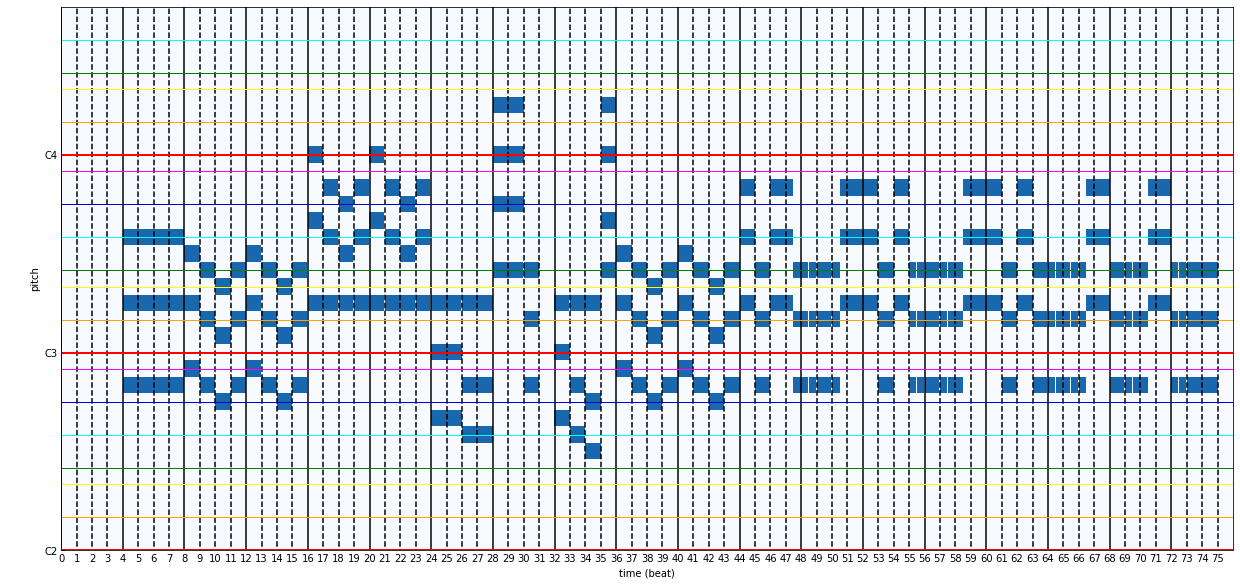

In [26]:
short_path = "q/queen/bohemian-rhapsody/pre-chorus-and-chorus_key.mid" # 2 bars file
long_path = "q/queen/bohemian-rhapsody/bridge_key.mid" # 19 bars_file
path = long_path
ppr, row = sampler.ppr_by_path(path)
bundles = bundler.bundle(ppr, row)

ppr.tracks.pop(0)
grid_plot(ppr)

path: q/queen/bohemian-rhapsody/bridge_key.mid
(1536, 128)
0.001683
chord_shape: (1536, 12)
offset: 48
pitch_range: [0, 12]


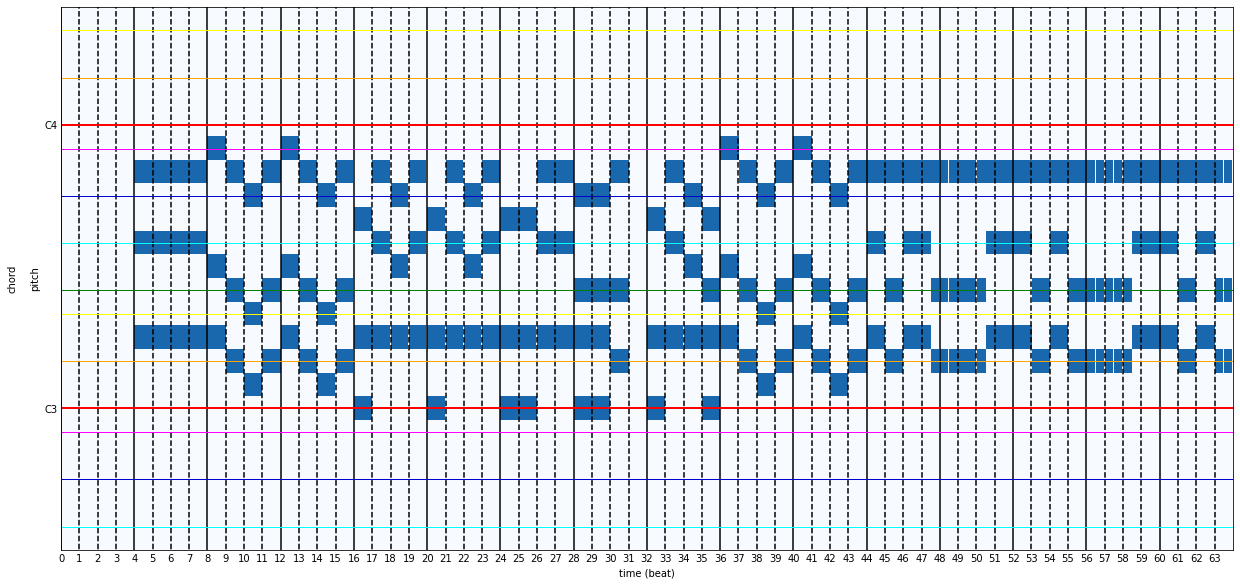

In [27]:
translate_chord = TranslateChordIntoPitchClasses()

ppr, row = sampler.ppr_by_path(path)
bundles = bundler.bundle(ppr, row)

bundle_id = 0
print(bundles[bundle_id].melody.shape)

# bundles = Binarize()(bundles)

with Timer():
    bundles = translate_chord(bundles)

bundle = bundles[0]

print(f"chord_shape: {bundle.chord.shape}")
print(f"offset: {bundle.meta['chord_offset']}")
print(f"pitch_range: {bundle.meta['chord_pitch_range']}")

bundle.melody = None
grid_plot(bundle.get_ppr())

### コードの空白部分をなるべく減らす
現在のステップの和音が，前のステップの和音の部分集合であるとき，前のステップの和音で上書きする  
ちなみに空集合はあらゆる集合の部分集合なので後ろに伸ばすことにもなる  
ちなみにPermeateは「染み渡らせる」という意味の英単語

In [28]:
class PermeateChord(BundlesProcessor):
    def process_bundle(self, bundle):
        pitch_range = bundle.meta.get('chord_pitch_range', [0,128])
        chord = bundle.chord[:, pitch_range[0]:pitch_range[1]]
        
        # 最初に音が鳴るステップを取得
        for i, step in enumerate(chord):
            if step.any():
                last_step = chord[i]
                break
        
        for step in range(len(chord)):
            # IF current ⊆ last THEN current ← last ELSE last ← current
            if np.any(chord[step] & ~last_step):
                last_step = chord[step]
            else:
                chord[step] = last_step
        
        bundle.chord = chord
        return bundle

動作確認

path: q/queen/bohemian-rhapsody/bridge_key.mid


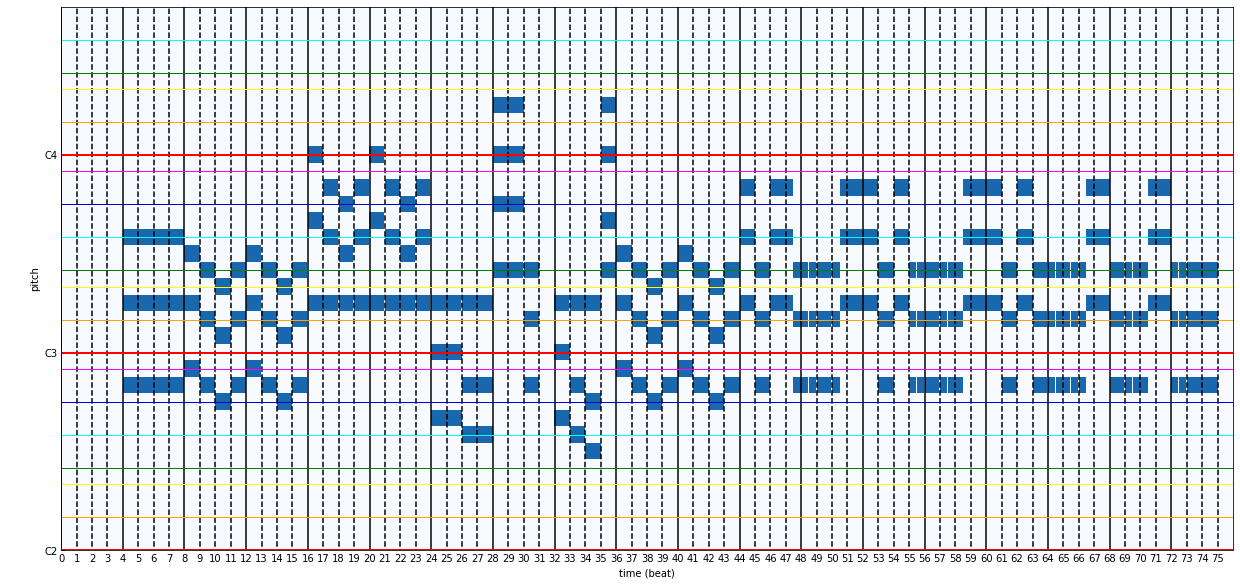

In [29]:
short_path = "q/queen/bohemian-rhapsody/pre-chorus-and-chorus_key.mid" # 2 bars file
long_path = "q/queen/bohemian-rhapsody/bridge_key.mid" # 19 bars_file
path = long_path
ppr, row = sampler.ppr_by_path(path)
bundles = bundler.bundle(ppr, row)

ppr.tracks.pop(0)
grid_plot(ppr)

path: q/queen/bohemian-rhapsody/bridge_key.mid
(1536, 12)
0.024096


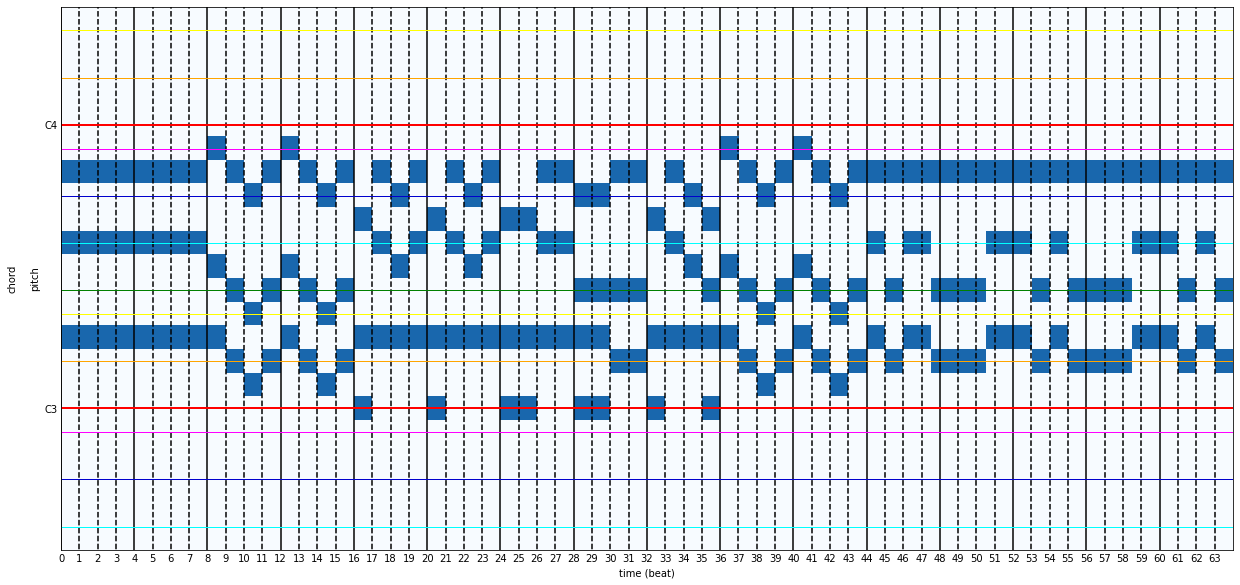

In [30]:
permeate_chord = PermeateChord()

ppr, row = sampler.ppr_by_path(path)
bundles = bundler.bundle(ppr, row)

bundles = TranslateChordIntoPitchClasses()(bundles)
print(bundles[bundle_id].chord.shape)

with Timer():
    bundles = permeate_chord(bundles)

bundle_id = 0
bundle = bundles[bundle_id]
bundle.melody = None
grid_plot(bundle.get_ppr())

さすがに若干重いか  
ほかの処理の10倍くらい

### 特殊ピッチをコードに加える
- id=12: PAD あとでPaddingでセット(chordとmelodyの長い方から先をPADにするため)

In [31]:
class AddSpecialPitchesToChord(BundlesProcessor):
    def process_bundle(self, bundle):
        chord = bundle.chord
        step_len, pitch_len = chord.shape
        
        extended_chord = np.zeros([step_len, pitch_len + 1], dtype=chord.dtype)
        extended_chord[:, :pitch_len] = chord
        
        bundle.chord = extended_chord
        return bundle

動作確認

path: q/queen/bohemian-rhapsody/bridge_key.mid
(1536, 128)
0.000026
(1536, 13)


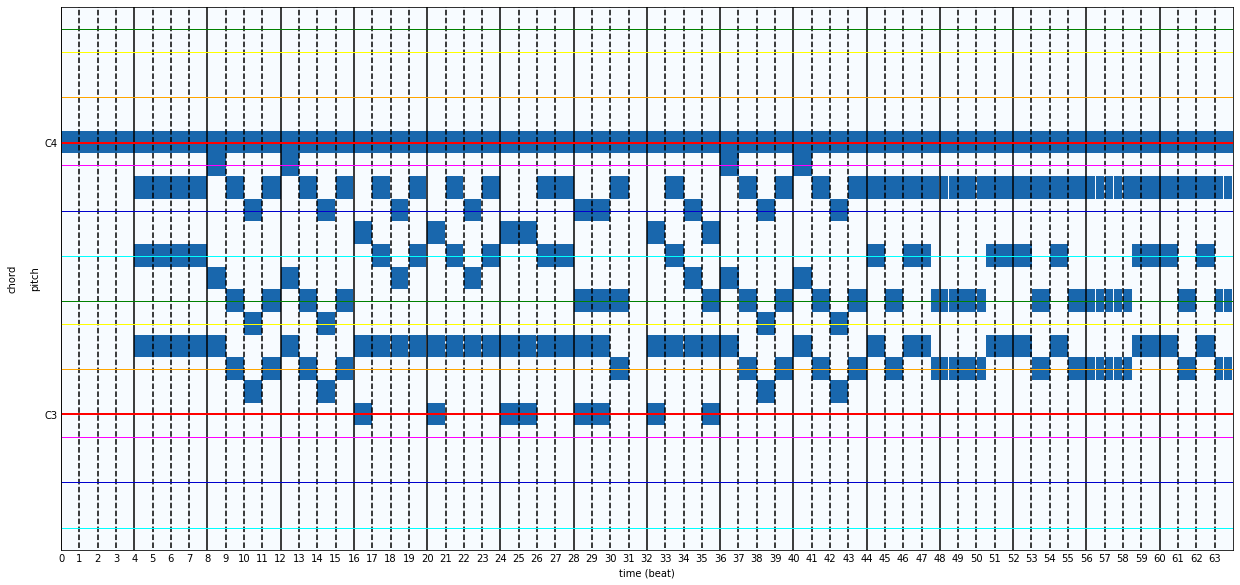

In [32]:
add_special_pitches_to_chord = AddSpecialPitchesToChord()

short_path = "q/queen/bohemian-rhapsody/pre-chorus-and-chorus_key.mid" # 2 bars file
long_path = "q/queen/bohemian-rhapsody/bridge_key.mid" # 19 bars_file
ppr, row = sampler.ppr_by_path(long_path)
bundles = bundler.bundle(ppr, row)

bundle_id = 0
print(bundles[bundle_id].chord.shape)

bundles = TranslateChordIntoPitchClasses()(bundles)

with Timer():
    bundles = add_special_pitches_to_chord(bundles)

bundle = bundles[bundle_id]

# show special pitches
bundle.chord[:, -1] = 1 if bundle.chord.dtype == bool else 100
bundle.meta['chord_pitch_range'] = [0, bundle.chord.shape[1]]

bundle.melody = None
print(bundle.chord.shape)
grid_plot(bundle.get_ppr())

### PADを設定
16小節に満たないBundleのPAD地点を1にする  
meta['bars'] = 16を設定

In [33]:
class Padding(BundlesProcessor):
    def __init__(self, bar_num=16, melody_pad_pitch=-1, chord_pad_pitch=-1, constant_velocity=100):
        self.bar_num = bar_num
        self.melody_pad_pitch = melody_pad_pitch
        self.chord_pad_pitch = chord_pad_pitch
        self.constant_velocity = constant_velocity
    
    def get_velocity(self, dtype):
        if dtype == bool:
            return 1
        else:
            return self.constant_velocity
    
    def process_bundle(self, bundle):
        melody, chord = bundle.melody, bundle.chord
        melody_len, melody_pitches = melody.shape
        chord_len, chord_pitches = chord.shape
        bundle_len = max(melody_len, chord_len)
        
        beats_in_bar = bundle.meta.get('beats_in_bar', 4)
        beat_res = bundle.meta.get('beat_resolution', 24)
        bar_res = beats_in_bar * beat_res
        song_len = bar_res * self.bar_num
        
        extended_melody = np.zeros([song_len, melody_pitches], dtype=melody.dtype)
        extended_chord = np.zeros([song_len, chord_pitches], dtype=chord.dtype)
        
        extended_melody[:melody_len, :] = melody
        extended_chord[:chord_len, :] = chord

        extended_melody[bundle_len:, self.melody_pad_pitch] = self.get_velocity(melody.dtype)
        extended_chord[bundle_len:, self.chord_pad_pitch] = self.get_velocity(chord.dtype)
        
        bundle.melody = extended_melody
        bundle.chord = extended_chord
        bundle.meta['bars'] = self.bar_num
        
        return bundle

動作確認

path: q/queen/bohemian-rhapsody/bridge_key.mid
melody shape (288, 128)
chord shape (288, 128)
0.001343
melody shape (1536, 128)
chord shape (1536, 128)


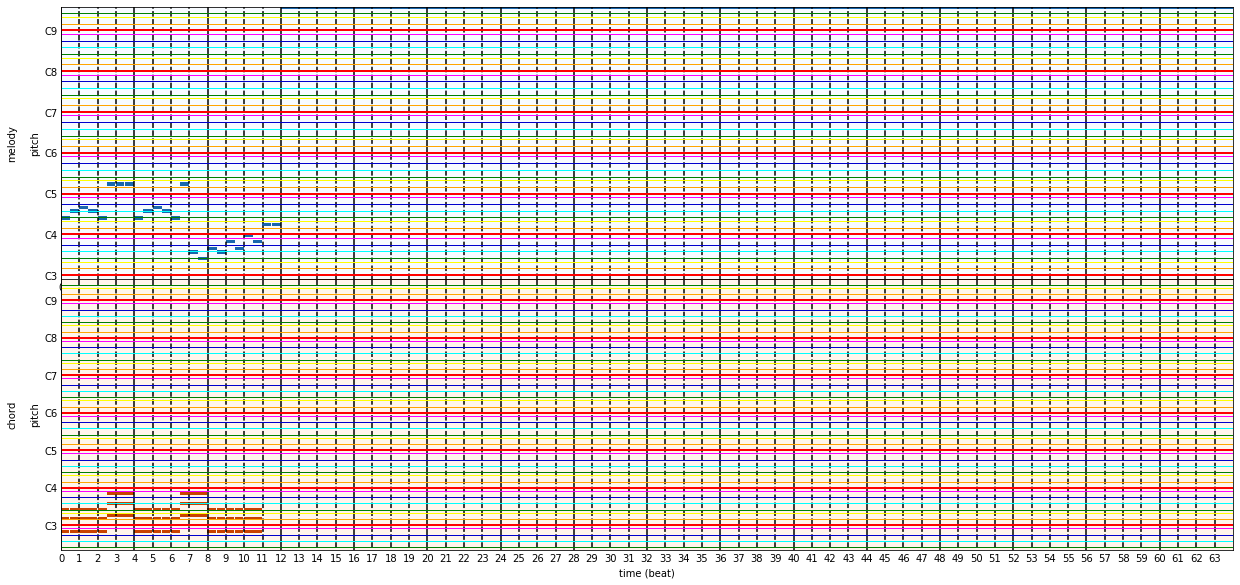

In [34]:
padding = Padding() # padが見えるようにあえてpadのIDを-1に設定

short_path = "q/queen/bohemian-rhapsody/pre-chorus-and-chorus_key.mid" # 2 bars file
long_path = "q/queen/bohemian-rhapsody/bridge_key.mid" # 19 bars_file
ppr, row = sampler.ppr_by_path(long_path)
bundles = bundler.bundle(ppr, row)

bundle_id = 1
print("melody shape", bundles[bundle_id].melody.shape)
print("chord shape", bundles[bundle_id].chord.shape)

with Timer():
    bundles = padding(bundles)

print("melody shape", bundles[bundle_id].melody.shape)
print("chord shape", bundles[bundle_id].chord.shape)

# bundles[bundle_id].melody=None
grid_plot(bundles[bundle_id].get_ppr())

## 全処理を統合
input: row -> output: bundlers
- ppr = Multitrack(os.path.join(input_dir, row['path']))
- PypianorollBundler.bundle(ppr, row)
- SequentialProcessor
    - RemoveEmptyBundles
    - RemoveShortBundles
    - Binarize
    - DownBeatResolution
    - Transpose
    - TrimMelodyInRange
    - AddSpecialPitchesToMelody
    - TranslateChordIntoPitchClasses
    - PermeateChord
    - AddSpecialPitchesToChord
    - Padding

In [35]:
bundler = PypianorollBundler()

sequential_processor = SequentialBundlesProcessor(processors=[
    RemoveEmptyBundles(),
    RemoveShortBundles(),
    Binarize(),
    DownBeatResolution(resolution_to=12),
    Transpose(),
    TrimMelodyInRange(bottom=36, top=99),
    AddSpecialPitchesToMelody(),
    TranslateChordIntoPitchClasses(),
    PermeateChord(),
    AddSpecialPitchesToChord(),
    Padding(),
])

stop_by_exception = False

def preprocess_theorytab_original(row):
    if type(row) == tuple:
        row = row[1]
    elif type(row) == pd.core.frame.DataFrame:
        row = row.iloc[0]
    path = row.path
    
    try:
        ppr = Multitrack(os.path.join(input_dir, path))
        bundles = bundler.bundle(ppr, row)
        bundles = sequential_processor(bundles)
    except Exception as e:
        if stop_by_exception: raise e
        return f"ERROR: {path}" # Means Error
    
    bundles = [bundle.get_dict() for bundle in bundles]
    
    return bundles # Valid Result even empty

単体動作テスト

song id: 839
id: 839
path: c/cyndi-lauper/she-bop/chorus_key.mid


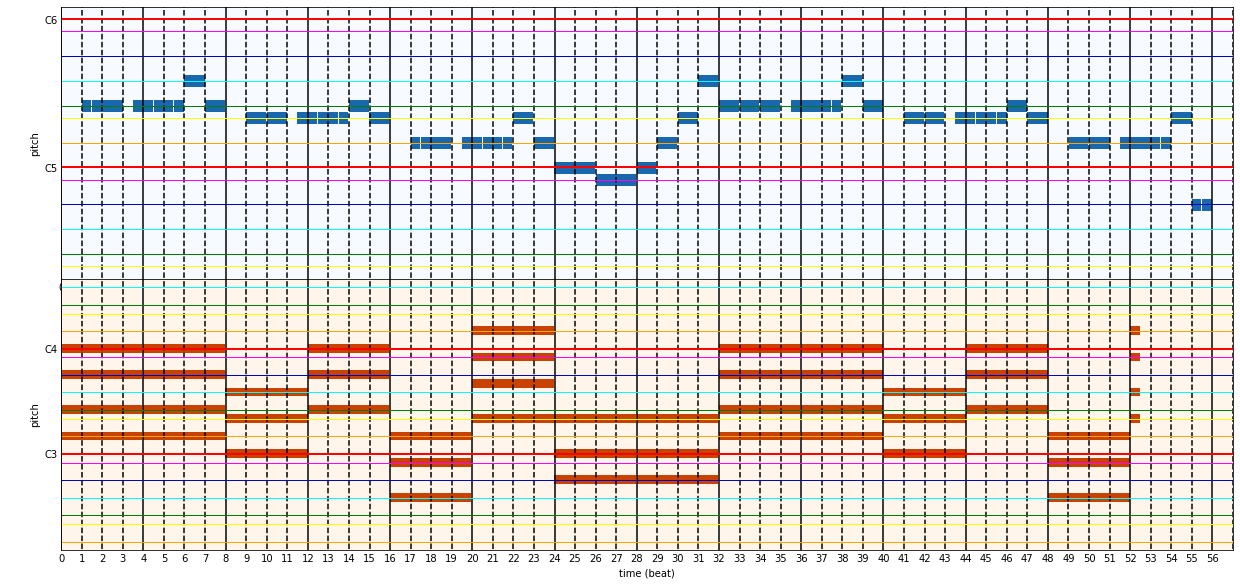

In [36]:
# song_id = random.randint(0, len(df))
song_id = 839 # 657は後半がEmpty
print("song id:", song_id)
ppr, row = sampler.ppr(song_id)
grid_plot(ppr)

0.019071
{'melody': array([[False, False, False, ...,  True, False, False],
       [False, False, False, ...,  True, False, False],
       [False, False, False, ...,  True, False, False],
       ...,
       [False, False, False, ..., False, False,  True],
       [False, False, False, ..., False, False,  True],
       [False, False, False, ..., False, False,  True]]), 'chord': array([[ True, False,  True, ..., False, False, False],
       [ True, False,  True, ..., False, False, False],
       [ True, False,  True, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False,  True],
       [False, False, False, ..., False, False,  True],
       [False, False, False, ..., False, False,  True]]), 'meta': {'range_from': 0, 'range_for': 14, 'original_bars': 14, 'beat_resolution': 12, 'beats_in_bar': 4, 'path': 'c/cyndi-lauper/she-bop/chorus_key.mid', 'bpm': 136, 'original_key': 'C Major', 'key': 'C Major', 'melody_offset': 36, 'melody_pitch_range': [0, 64], 'chord_

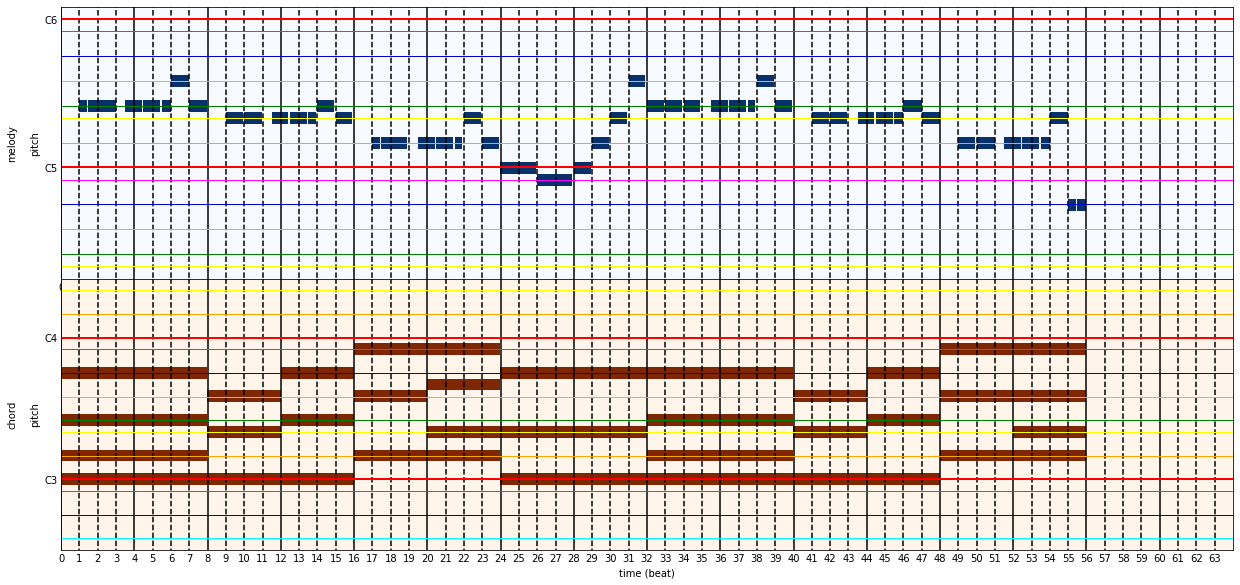

In [37]:
with Timer():
    bundles = preprocess_theorytab_original(row)

bundle_id = 0
bundle = Bundle().set_dict(bundles[bundle_id])
print(bundle.get_dict())
print(bundle.melody.shape)
print(bundle.chord.shape)
grid_plot(bundle.get_ppr())

## 全体を並列処理

In [38]:
output_path = os.path.join(output_dir, "original.hkl")
multi_processing = 25
dataset = df
process_func = preprocess_theorytab_original

In [39]:
print("start preprocessing...")
if multi_processing > 0:
    pool = Pool(multi_processing)
    with Timer():
        result_bundles_list = pool.map(process_func, dataset.iterrows())
else:
    with Timer():
        result_bundles_list = map(process_func, dataset.iterrows())

print("unpacking result bundles list...")
bundle_list = []
error_list = []
with Timer():
    for bundles in result_bundles_list:
        if type(bundles) is str:
            error_list.append(bundles.split(' ')[-1])
        else:
            for bundle in bundles:
                bundle_list.append(bundle)

print("Preprocessing Finished!")
print(f"{len(bundle_list)} bundles created")
print(f"{len(error_list)} error caused")

start preprocessing...
18.088477
unpacking result bundles list...
0.019299
Preprocessing Finished!
17396 bundles created
0 error caused


In [41]:
print("error file paths")
if not error_list:
    print("no error files!")
for error_path in error_list:
    print(error_path)

error file paths
no error files!


### 保存と読込

保存: 約15\~20分  
読込: 約3\~5分  
データサイズ: 約1.5G

In [42]:
with Timer():
    hkl.dump(bundle_list, output_path, mode='w')

977.010061


In [43]:
with Timer():
     bundle_list = hkl.load(output_path)

print(len(bundle_list))

211.793737
17396


id: 9994
{'chord': array([[False, False, False, ...,  True, False, False],
       [False, False, False, ...,  True, False, False],
       [False, False, False, ...,  True, False, False],
       ...,
       [False, False,  True, ..., False,  True, False],
       [False, False,  True, ..., False,  True, False],
       [False, False,  True, ..., False,  True, False]]), 'melody': array([[False, False, False, ...,  True, False, False],
       [False, False, False, ...,  True, False, False],
       [False, False, False, ...,  True, False, False],
       ...,
       [False, False, False, ...,  True, False, False],
       [False, False, False, ...,  True, False, False],
       [False, False, False, ...,  True, False, False]]), 'meta': {'bars': 16, 'beat_resolution': 12, 'beats_in_bar': 4, 'bpm': 151, 'chord_offset': 48, 'chord_pitch_range': [0, 12], 'key': 'Eb Major', 'melody_offset': 36, 'melody_pitch_range': [0, 64], 'original_bars': 16, 'original_key': 'F Major', 'path': 'h/honoka-kousaka--

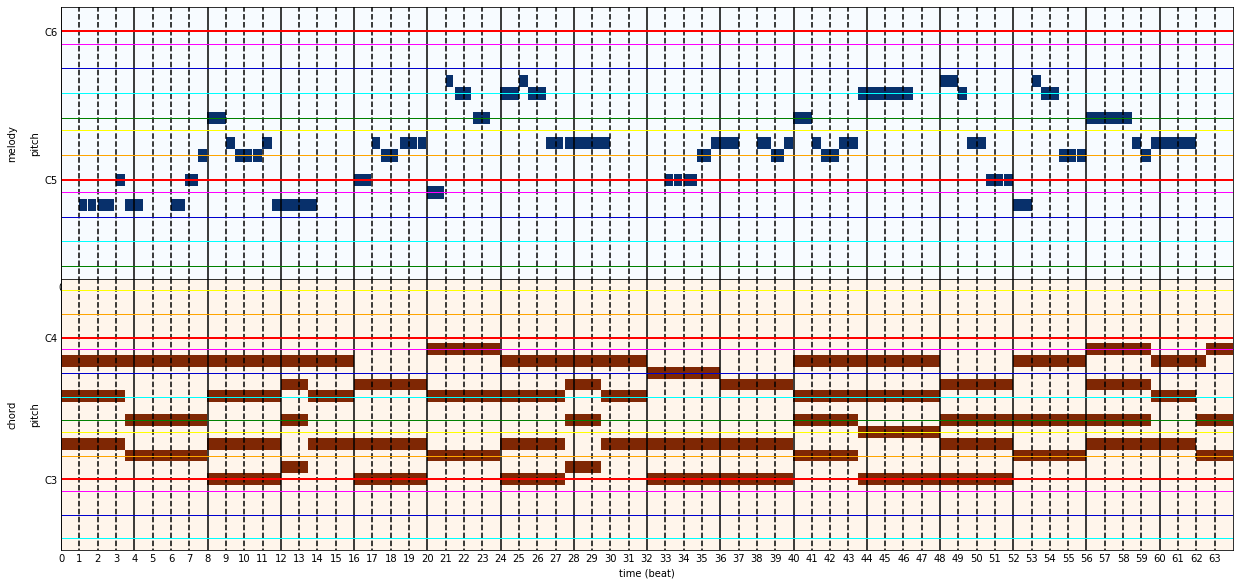

In [47]:
bundle_id = random.randint(0, len(bundle_list))
print("id:", bundle_id)

bundle = bundle_list[bundle_id]
print(bundle)

bundle = Bundle().set_dict(bundle)
grid_plot(bundle.get_ppr())